# Libraries

In [2]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import r2_score

# visualization
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline

# preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# models
import statsmodels.api as sm
from statsmodels.formula.api import ols

---

# 3.27 Predicting Car Prices

Multiple regression: Multiple independent variables. Example- predicting price of car based on body style, brand, mileage, etc.

Multi**variate** regression: Multiple dependent variables (things you're trying to predict)

Based on the EDA below, summary of plan to predict price:
- ohe Make, Type
- independent vars: mileage, make, type, cylinders, doors, cruise, leather
- re doors: once ohe type, and scale the df, see correlation between doors and type. this could be multcol.
- linreg price vs mileage, make, cylinders?

In [3]:
cars = pd.read_excel('http://cdn.sundog-soft.com/Udemy/DataScience/cars.xls')
cars.head()

,Price,Mileage,Make,Model,Trim,Type,Cylinder,Liter,Doors,Cruise,Sound,Leather
0,17314.103129,8221,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,1
1,17542.036083,9135,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
2,16218.847862,13196,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
3,16336.913140,16342,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,0
4,16339.170324,19832,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,1


In [4]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804 entries, 0 to 803
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     804 non-null    float64
 1   Mileage   804 non-null    int64  
 2   Make      804 non-null    object 
 3   Model     804 non-null    object 
 4   Trim      804 non-null    object 
 5   Type      804 non-null    object 
 6   Cylinder  804 non-null    int64  
 7   Liter     804 non-null    float64
 8   Doors     804 non-null    int64  
 9   Cruise    804 non-null    int64  
 10  Sound     804 non-null    int64  
 11  Leather   804 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 75.5+ KB


In [5]:
cars.describe()

,Price,Mileage,Cylinder,Liter,Doors,Cruise,Sound,Leather
count,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000
mean,21343.143767,19831.934080,5.268657,3.037313,3.527363,0.752488,0.679104,0.723881
std,9884.852801,8196.319707,1.387531,1.105562,0.850169,0.431836,0.467111,0.447355
min,8638.930895,266.000000,4.000000,1.600000,2.000000,0.000000,0.000000,0.000000
25%,14273.073870,14623.500000,4.000000,2.200000,4.000000,1.000000,0.000000,0.000000
50%,18024.995019,20913.500000,6.000000,2.800000,4.000000,1.000000,1.000000,1.000000
75%,26717.316636,25213.000000,6.000000,3.800000,4.000000,1.000000,1.000000,1.000000
max,70755.466717,50387.000000,8.000000,6.000000,4.000000,1.000000,1.000000,1.000000


In [6]:
corr = cars.corr()
corr

,Price,Mileage,Cylinder,Liter,Doors,Cruise,Sound,Leather
Price,1.000000,-0.143051,0.569086,0.558146,-0.138750,0.430851,-0.124348,0.157197
Mileage,-0.143051,1.000000,-0.029461,-0.018641,-0.016944,0.025037,-0.026146,0.001005
Cylinder,0.569086,-0.029461,1.000000,0.957897,0.002206,0.354285,-0.089704,0.075520
Liter,0.558146,-0.018641,0.957897,1.000000,-0.079259,0.377509,-0.065527,0.087332
Doors,-0.138750,-0.016944,0.002206,-0.079259,1.000000,-0.047674,-0.062530,-0.061969
Cruise,0.430851,0.025037,0.354285,0.377509,-0.047674,1.000000,-0.091730,-0.070573
Sound,-0.124348,-0.026146,-0.089704,-0.065527,-0.062530,-0.091730,1.000000,0.165444
Leather,0.157197,0.001005,0.075520,0.087332,-0.061969,-0.070573,0.165444,1.000000


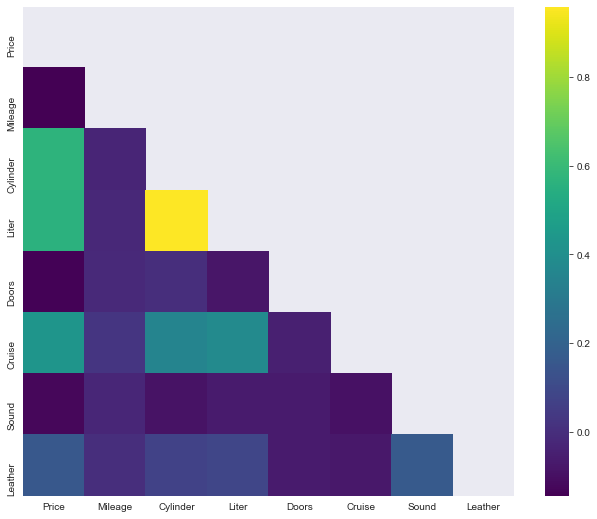

In [7]:
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, ax=ax, cmap="viridis");

I'm surprised mileage isn't more correlated with price, so let's check it out below:

### Mileage vs Price

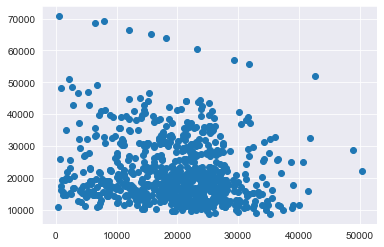

In [8]:
plt.scatter(cars.Mileage, cars.Price);

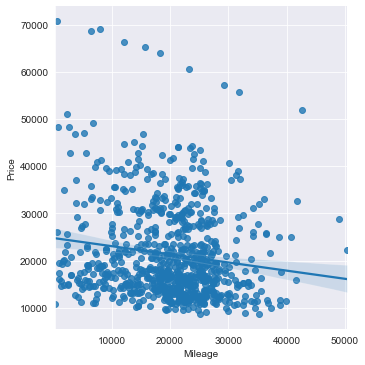

In [9]:
sns.lmplot(data=cars, x='Mileage', y='Price');

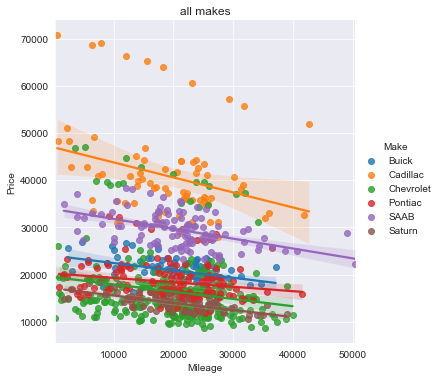

In [10]:
# LM Plot for the entire price vs mileage data

sns.lmplot(data=cars, x='Mileage', y='Price', hue='Make')
plt.title('all makes');

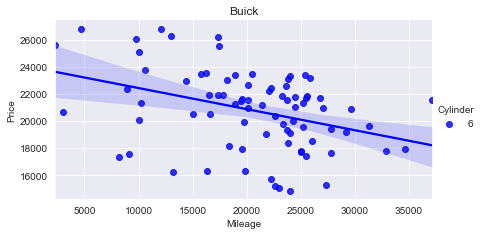

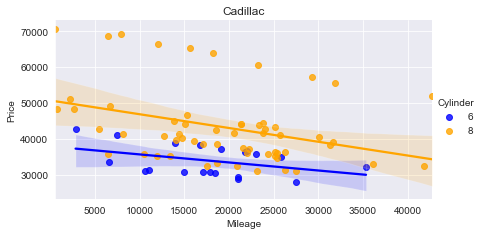

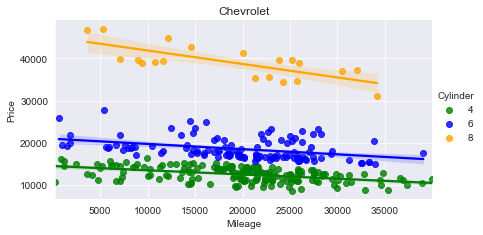

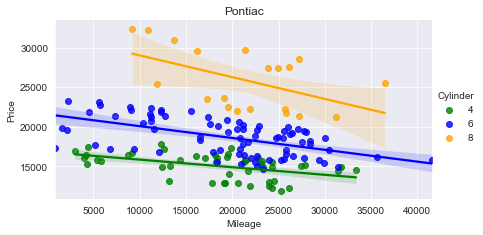

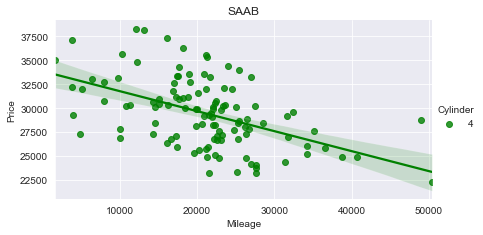

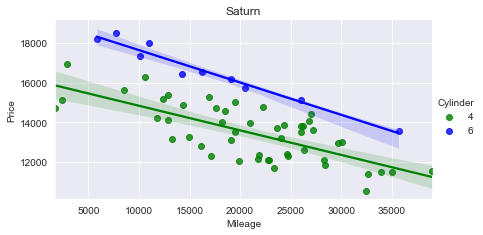

In [11]:
# LM Plot, by make, Milieage vs Price

car_makes = ['Buick', 'Cadillac', 'Chevrolet', 'Pontiac', 'SAAB', 'Saturn']

for car_make in car_makes:
    sns.lmplot(data=cars[cars.Make == car_make], x='Mileage', y='Price', height=3, aspect=2, 
               hue='Cylinder', palette={4:'g', 6:'b', 8:'orange'}) 
    plt.title(car_make);

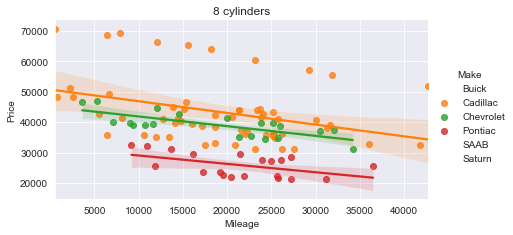

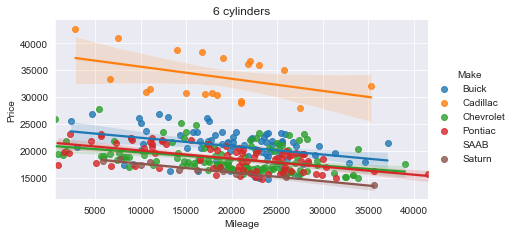

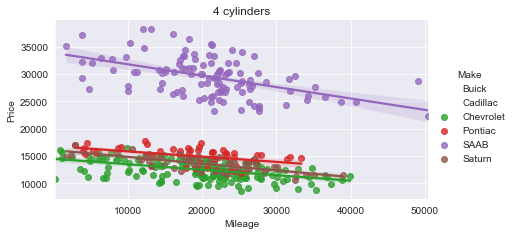

In [12]:
cylinders = [8, 6, 4]

for cylinder in cylinders:
    sns.lmplot(data=cars[cars.Cylinder == cylinder], x='Mileage', y='Price', height=3, aspect=2, hue='Make',
               hue_order=car_makes)
    plt.title(f'{cylinder} cylinders');

So there IS a correlation between mileage and price,

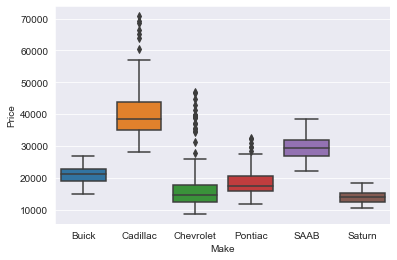

In [13]:
sns.boxplot(data=cars, x='Make', y='Price');

So, cruise and cylinder, both numerical values, have a relatively high positive correlation with price.

Let's look at type (categorical) and doors (numerical) real quick. 

I'm thinking ohe the categoricals, and then scale, and then we can do the linear regression.

Also, do a linear regression individually against features, and then altogether. And compare the difference.

In [14]:
cars.head()

,Price,Mileage,Make,Model,Trim,Type,Cylinder,Liter,Doors,Cruise,Sound,Leather
0,17314.103129,8221,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,1
1,17542.036083,9135,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
2,16218.847862,13196,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
3,16336.913140,16342,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,0
4,16339.170324,19832,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,1


In [15]:
cars.Trim.value_counts().head()

# discard this feature.

Sedan 4D       170
Coupe 2D        50
LS Sedan 4D     50
LS Coupe 2D     30
LT Sedan 4D     30
Name: Trim, dtype: int64

In [16]:
cars.Type.unique()

array(['Sedan', 'Convertible', 'Hatchback', 'Coupe', 'Wagon'],
      dtype=object)

#### New df with isolated features

In [17]:
carsLinreg_df = cars[['Price', 'Mileage', 'Make', 'Type', 'Cylinder', 'Doors', 'Cruise', 'Leather']]
carsLinreg_df.sample(20)

,Price,Mileage,Make,Type,Cylinder,Doors,Cruise,Leather
660,26841.080835,10003,SAAB,Sedan,4,4,1,0
430,18974.922030,5632,Chevrolet,Hatchback,6,4,0,1
280,15553.208714,7695,Chevrolet,Sedan,4,4,0,1
622,16379.098701,8754,Pontiac,Wagon,4,4,0,0
12,20512.094091,16633,Buick,Sedan,6,4,1,0
300,15635.796160,1169,Chevrolet,Coupe,4,2,0,1
397,16543.980137,24583,Chevrolet,Hatchback,6,4,0,1
323,15163.169859,17158,Chevrolet,Sedan,4,4,1,1
357,34297.305350,24259,Chevrolet,Coupe,8,2,1,1
704,29914.379575,22105,SAAB,Wagon,4,4,1,1


In [18]:
carsLinreg_df.describe()

,Price,Mileage,Cylinder,Doors,Cruise,Leather
count,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000
mean,21343.143767,19831.934080,5.268657,3.527363,0.752488,0.723881
std,9884.852801,8196.319707,1.387531,0.850169,0.431836,0.447355
min,8638.930895,266.000000,4.000000,2.000000,0.000000,0.000000
25%,14273.073870,14623.500000,4.000000,4.000000,1.000000,0.000000
50%,18024.995019,20913.500000,6.000000,4.000000,1.000000,1.000000
75%,26717.316636,25213.000000,6.000000,4.000000,1.000000,1.000000
max,70755.466717,50387.000000,8.000000,4.000000,1.000000,1.000000


In [19]:
carsLinreg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804 entries, 0 to 803
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     804 non-null    float64
 1   Mileage   804 non-null    int64  
 2   Make      804 non-null    object 
 3   Type      804 non-null    object 
 4   Cylinder  804 non-null    int64  
 5   Doors     804 non-null    int64  
 6   Cruise    804 non-null    int64  
 7   Leather   804 non-null    int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 50.4+ KB


# OLS (udemy) vs ols (flatiron)

Looks like the ols (flatiron) one gives a y-intercept. Let's see

- going to use mileage, cylinders and doors

# OLS (udemy)

In [20]:
# define feature and target variables
X = carsLinreg_df[['Mileage', 'Cylinder', 'Doors']]
y = carsLinreg_df[['Price']]

# scale features
ss = StandardScaler()
X_ss = pd.DataFrame(ss.fit_transform(X),
                    index= X.index,
                    columns= X.columns)

HOLY SHIT! When using OLS, we need to add a constant. I kept seeing the .add_constant method all over SOf but didn't know what or why people were adding it. Eventually it dawned on me that this might be the equivalent of the intercept in the ols. I tried it and voila! Now it matches the ols result...

In [85]:
X_ss = sm.add_constant(X_ss)

X_ss.head()

,const,Mileage,Cylinder,Doors
0,1.0,-1.417485,0.52741,0.556279
1,1.0,-1.305902,0.52741,0.556279
2,1.0,-0.810128,0.52741,0.556279
3,1.0,-0.426058,0.52741,0.556279
4,1.0,0.000008,0.52741,0.556279


In [22]:
# linreg
model_OLS = sm.OLS(y, X_ss).fit()
model_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     150.0
Date:                Mon, 01 Mar 2021   Prob (F-statistic):           3.95e-77
Time:                        07:36:29   Log-Likelihood:                -8356.7
No. Observations:                 804   AIC:                         1.672e+04
Df Residuals:                     800   BIC:                         1.674e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.134e+04    279.405     76.388      0.000    2.08e+04    2.19e+04
Mileage    -1272.3412    279.567     -4.551      0.000   -1821.112    -723.571
Cylinder    5587.4472    279.527     19.989      0.000    5038.754    6136.140
Doors      -1404.5513    279.446     -5.026      0.000   -1953.085    -856.018
==============================================================================
Omnibus:                      157.913   Durbin-Watson:                   0.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              257.529
Skew:                           1.278   Prob(JB):                     1.20e-56
Kurtosis:                       4.074   Cond. No.                         1.03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Predicting price for car with 45k miles, 8 cylinders and 4 doors using the model above.

Start by scaling your multiple feature variables into the same scale used to train the model, then just call est.predict() on the scaled features:

In [37]:
help(sm.graphics.plot_regress_exog)

Help on function plot_regress_exog in module statsmodels.graphics.regressionplots:

plot_regress_exog(results, exog_idx, fig=None)
    Plot regression results against one regressor.
    
    This plots four graphs in a 2 by 2 figure: 'endog versus exog',
    'residuals versus exog', 'fitted versus exog' and
    'fitted plus residual versus exog'
    
    Parameters
    ----------
    results : result instance
        A result instance with resid, model.endog and model.exog as attributes.
    exog_idx : int or str
        Name or index of regressor in exog matrix.
    fig : Figure, optional
        If given, this figure is simply returned.  Otherwise a new figure is
        created.
    
    Returns
    -------
    Figure
        The value of `fig` if provided. Otherwise a new instance.
    
    Examples
    --------
    Load the Statewide Crime data set and build a model with regressors
    including the rate of high school graduation (hs_grad), population in urban
    areas (urban), h

In [23]:
X_ss.iloc[:,1:4].columns

Index(['Mileage', 'Cylinder', 'Doors'], dtype='object')

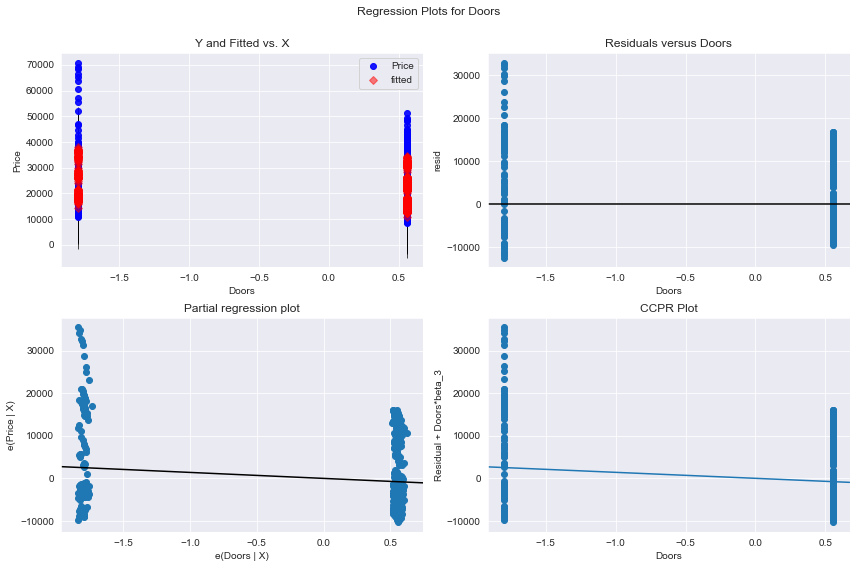

In [59]:
# flatiron youtube- Linear Regression 2 (43:04)

sm.graphics.plot_regress_exog(model_OLS, 'Doors', fig=plt.figure(figsize=(12,8)));

# Can only be graphed using ONE regressor or independent variable
# Understanding the assumptions will help with understanding the graphs below.

In [33]:
# scaling the values we're trying to predict from against the scaled values of our model above
scaledPredicting = ss.transform([[45000, 8, 4]])

scaledPredicting

array([[3.07256589, 1.96971667, 0.55627894]])

In [34]:
scaledPredicting = sm.add_constant(scaledPredicting,has_constant='add')
scaledPredicting

array([[1.        , 3.07256589, 1.96971667, 0.55627894]])

In [35]:
# predicting based on the scaled values we defined in the previous line above
OLS_prediction = model_OLS.predict(scaledPredicting)

print(OLS_prediction)

[27658.15707316]


# ols (Flatiron)

We need to combine the price with the scaled values here in a new dataframe

In [89]:
ols_fsm_df = y.join(X_ss.iloc[:,1:4])

ols_fsm_df.head()

,Price,Mileage,Cylinder,Doors
0,17314.103129,-1.417485,0.52741,0.556279
1,17542.036083,-1.305902,0.52741,0.556279
2,16218.847862,-0.810128,0.52741,0.556279
3,16336.913140,-0.426058,0.52741,0.556279
4,16339.170324,0.000008,0.52741,0.556279


In [37]:
f = 'Price ~ Mileage + Cylinder + Doors'

model_ols = ols(formula= f, data= ols_fsm_df).fit()
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     150.0
Date:                Mon, 01 Mar 2021   Prob (F-statistic):           3.95e-77
Time:                        14:29:13   Log-Likelihood:                -8356.7
No. Observations:                 804   AIC:                         1.672e+04
Df Residuals:                     800   BIC:                         1.674e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.134e+04    279.405     76.388      0.000    2.08e+04    2.19e+04
Mileage    -1272.3412    279.567     -4.551      0.000   -1821.112    -723.571
Cylinder    5587.4472    279.527     19.989      0.000    5038.754    6136.140
Doors      -1404.5513    279.446     -5.026      0.000   -1953.085    -856.018
==============================================================================
Omnibus:                      157.913   Durbin-Watson:                   0.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              257.529
Skew:                           1.278   Prob(JB):                     1.20e-56
Kurtosis:                       4.074   Cond. No.                         1.03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


Let's make the same prediction from the ols model with the OLS model. Going to use the same params, which we already scaled above.

In [48]:
# let's get the coef from our ols model

model_ols.params

Intercept    21343.143767
Mileage      -1272.341233
Cylinder      5587.447216
Doors        -1404.551343
dtype: float64

In [49]:
# isolating the coefs for mileage, cylinder, doors.
# IMPORTANT: these coefs are based on the scaled values of ea of those features. Not the actual.

model_ols.params[1:4]

Mileage    -1272.341233
Cylinder    5587.447216
Doors      -1404.551343
dtype: float64

In [54]:
#scaled values of 45k, 8 cylinders, and 4 doors

print(scaledPredicting[0][1:4])

[3.07256589 1.96971667 0.55627894]


In [57]:
print('ss val of 45k miles= ', scaledPredicting[0][1], 
      '\nmodel coef for miles=', model_ols.params[1])

print('45k miles affect on price:', scaledPredicting[0][0] * model_ols.params[1])

ss val of 45k miles=  3.0725658855625904 
model coef for miles= -1272.3412330664978
45k miles affect on price: -1272.3412330664978


In [46]:
model_ols.params[1:4]

Mileage    -1272.341233
Cylinder    5587.447216
Doors      -1404.551343
dtype: float64

In [55]:
eaFeature_pred = model_ols.params[1:4] * scaledPredicting[0][1:4]
eaFeature_pred

Mileage     -3909.352268
Cylinder    11005.687899
Doors        -781.322326
dtype: float64

In [56]:
eaFeature_predSum = sum(model_ols.params[1:4] * scaledPredicting[0][1:4])
eaFeature_predSum

6315.013305830601

In [58]:
print(eaFeature_pred[0], eaFeature_pred[1], eaFeature_pred[2])
print(eaFeature_pred[0] + eaFeature_pred[1] + eaFeature_pred[2])

-3909.352267514762 11005.68789910673 -781.3223257613676
6315.013305830601


In [59]:
model_ols.params[0] + eaFeature_predSum

27658.157073156442

---

I couldn't run the following code below:

pd.DataFrame(scaledPredicting[0][1:4], columns= ['Mileage', 'Cylinder', 'Doors'])

so the next few cells are me trying to figure out why. Turns out i had to surround scaledPredicting with hard brackets... I have pasted the link below

In [76]:
scaledPredicting

array([[1.        , 3.07256589, 1.96971667, 0.55627894]])

In [72]:
pd.DataFrame(scaledPredicting)

,0,1,2,3
0,1.0,3.072566,1.969717,0.556279


In [74]:
scaledPredicting[0][1:4]

array([3.07256589, 1.96971667, 0.55627894])

In [71]:
pd.DataFrame(scaledPredicting[0][1:4])

,0
0,3.072566
1,1.969717
2,0.556279


---

In [83]:
# turns out I have to feed in a dataframe of scaled values to predict. It has to be a df, else it'll give an error
# I'm testing out how to make the dataframehere, and then feed it into the next cell for the prediction.
# https://stackoverflow.com/questions/45327069/convert-numpy-array-to-pandas-dataframe-column-wise-as-single-row

pd.DataFrame([scaledPredicting[0][1:4]], columns= ['Mileage', 'Cylinder', 'Doors'])

,Mileage,Cylinder,Doors
0,3.072566,1.969717,0.556279


In [81]:
ols_prediction = model_ols.predict(pd.DataFrame([scaledPredicting[0][1:4]], 
                                                columns= ['Mileage', 'Cylinder', 'Doors']))

ols_prediction

0    27658.157073
dtype: float64

# OHE Make & Type

In [49]:
carsLinreg_df.Make.unique()

array(['Buick', 'Cadillac', 'Chevrolet', 'Pontiac', 'SAAB', 'Saturn'],
      dtype=object)

In [50]:
carsLinreg_df.Type.unique()

array(['Sedan', 'Convertible', 'Hatchback', 'Coupe', 'Wagon'],
      dtype=object)

# OHE Make- Dropping first col

I'm going to add this back to price and run ols

In [131]:
ohe = OneHotEncoder(drop='first')

oheMake = ohe.fit_transform(carsLinreg_df[['Make']])
oheMake.todense()

matrix([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]])

In [132]:
ohe.get_feature_names()

array(['x0_Cadillac', 'x0_Chevrolet', 'x0_Pontiac', 'x0_SAAB',
       'x0_Saturn'], dtype=object)

In [133]:
oheMakeDropped_df = pd.DataFrame(oheMake.todense(), 
                          index=carsLinreg_df.index, 
                          columns=ohe.get_feature_names(carsLinreg_df[['Make']].columns))

oheMakeDropped_df

,Make_Cadillac,Make_Chevrolet,Make_Pontiac,Make_SAAB,Make_Saturn
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
799,0.0,0.0,0.0,0.0,1.0
800,0.0,0.0,0.0,0.0,1.0
801,0.0,0.0,0.0,0.0,1.0
802,0.0,0.0,0.0,0.0,1.0


In [134]:
y

,Price
0,17314.103129
1,17542.036083
2,16218.847862
3,16336.913140
4,16339.170324
...,...
799,16507.070267
800,16175.957604
801,15731.132897
802,15118.893228


In [135]:
ols_MakeDropped_df = y.join(oheMakeDropped_df)
ols_MakeDropped_df

,Price,Make_Cadillac,Make_Chevrolet,Make_Pontiac,Make_SAAB,Make_Saturn
0,17314.103129,0.0,0.0,0.0,0.0,0.0
1,17542.036083,0.0,0.0,0.0,0.0,0.0
2,16218.847862,0.0,0.0,0.0,0.0,0.0
3,16336.913140,0.0,0.0,0.0,0.0,0.0
4,16339.170324,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
799,16507.070267,0.0,0.0,0.0,0.0,1.0
800,16175.957604,0.0,0.0,0.0,0.0,1.0
801,15731.132897,0.0,0.0,0.0,0.0,1.0
802,15118.893228,0.0,0.0,0.0,0.0,1.0


In [136]:
ols_MakeDropped_df.columns

Index(['Price', 'Make_Cadillac', 'Make_Chevrolet', 'Make_Pontiac', 'Make_SAAB',
       'Make_Saturn'],
      dtype='object')

In [138]:
f = 'Price ~ Make_Cadillac + Make_Chevrolet + Make_Pontiac + Make_SAAB + Make_Saturn'

model_ols_MakeDropped = ols(formula= f, data= ols_MakeDropped_df).fit()
model_ols_MakeDropped.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     289.6
Date:                Tue, 02 Mar 2021   Prob (F-statistic):          1.53e-176
Time:                        14:19:58   Log-Likelihood:                -8120.1
No. Observations:                 804   AIC:                         1.625e+04
Df Residuals:                     798   BIC:                         1.628e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2.082e+04    660.820     31.499      0.000    1.95e+04    2.21e+04
Make_Cadillac   2.012e+04    934.541     21.531      0.000    1.83e+04     2.2e+04
Make_Chevrolet -4387.5145    738.820     -5.939      0.000   -5837.774   -2937.255
Make_Pontiac   -2403.0135    818.280     -2.937      0.003   -4009.248    -796.779
Make_SAAB       8679.5908    862.049     10.069      0.000    6987.440    1.04e+04
Make_Saturn    -6836.3063   1009.420     -6.773      0.000   -8817.738   -4854.875
==============================================================================
Omnibus:                      410.940   Durbin-Watson:                   0.219
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2664.441
Skew:                           2.270   Prob(JB):                         0.00
Kurtosis:                      10.676   Cond. No.                         9.15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [139]:
model_ols_MakeDropped.params

Intercept         20815.113883
Make_Cadillac     20121.221564
Make_Chevrolet    -4387.514536
Make_Pontiac      -2403.013462
Make_SAAB          8679.590804
Make_Saturn       -6836.306323
dtype: float64

# OHE Make- Keeping all cols

In [117]:
carsLinreg_df

,Price,Mileage,Make,Type,Cylinder,Doors,Cruise,Leather
0,17314.103129,8221,Buick,Sedan,6,4,1,1
1,17542.036083,9135,Buick,Sedan,6,4,1,0
2,16218.847862,13196,Buick,Sedan,6,4,1,0
3,16336.913140,16342,Buick,Sedan,6,4,1,0
4,16339.170324,19832,Buick,Sedan,6,4,1,1
...,...,...,...,...,...,...,...,...
799,16507.070267,16229,Saturn,Sedan,6,4,1,0
800,16175.957604,19095,Saturn,Sedan,6,4,1,0
801,15731.132897,20484,Saturn,Sedan,6,4,1,0
802,15118.893228,25979,Saturn,Sedan,6,4,1,0


In [140]:
ohe = OneHotEncoder()

oheMake = ohe.fit_transform(carsLinreg_df[['Make']])

oheMake_df = pd.DataFrame(oheMake.todense(), 
                          index=carsLinreg_df.index, 
                          columns=ohe.get_feature_names(carsLinreg_df[['Make']].columns))

oheMake_df

,Make_Buick,Make_Cadillac,Make_Chevrolet,Make_Pontiac,Make_SAAB,Make_Saturn
0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
799,0.0,0.0,0.0,0.0,0.0,1.0
800,0.0,0.0,0.0,0.0,0.0,1.0
801,0.0,0.0,0.0,0.0,0.0,1.0
802,0.0,0.0,0.0,0.0,0.0,1.0


In [141]:
ols_Make_df = y.join(oheMake_df)
ols_Make_df

,Price,Make_Buick,Make_Cadillac,Make_Chevrolet,Make_Pontiac,Make_SAAB,Make_Saturn
0,17314.103129,1.0,0.0,0.0,0.0,0.0,0.0
1,17542.036083,1.0,0.0,0.0,0.0,0.0,0.0
2,16218.847862,1.0,0.0,0.0,0.0,0.0,0.0
3,16336.913140,1.0,0.0,0.0,0.0,0.0,0.0
4,16339.170324,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
799,16507.070267,0.0,0.0,0.0,0.0,0.0,1.0
800,16175.957604,0.0,0.0,0.0,0.0,0.0,1.0
801,15731.132897,0.0,0.0,0.0,0.0,0.0,1.0
802,15118.893228,0.0,0.0,0.0,0.0,0.0,1.0


In [142]:
f = 'Price ~ Make_Buick + Make_Cadillac + Make_Chevrolet + Make_Pontiac + Make_SAAB + Make_Saturn'

model_ols_Make = ols(formula= f, data= ols_Make_df).fit()
model_ols_Make.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     289.6
Date:                Tue, 02 Mar 2021   Prob (F-statistic):          1.53e-176
Time:                        14:21:25   Log-Likelihood:                -8120.1
No. Observations:                 804   AIC:                         1.625e+04
Df Residuals:                     798   BIC:                         1.628e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2.001e+04    207.223     96.559      0.000    1.96e+04    2.04e+04
Make_Buick       805.8765    595.700      1.353      0.176    -363.447    1975.200
Make_Cadillac   2.093e+04    595.700     35.130      0.000    1.98e+04    2.21e+04
Make_Chevrolet -3581.6380    347.736    -10.300      0.000   -4264.224   -2899.052
Make_Pontiac   -1597.1369    457.490     -3.491      0.001   -2495.163    -699.111
Make_SAAB       9485.4674    511.694     18.537      0.000    8481.043    1.05e+04
Make_Saturn    -6030.4298    677.370     -8.903      0.000   -7360.068   -4700.792
==============================================================================
Omnibus:                      410.940   Durbin-Watson:                   0.219
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2664.441
Skew:                           2.270   Prob(JB):                         0.00
Kurtosis:                      10.676   Cond. No.                     6.80e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.18e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [116]:
# Model params from dataframe with ALL dummy columns

model_ols_Make.params

Intercept         20009.237335
Make_Buick          805.876548
Make_Cadillac     20927.098112
Make_Chevrolet    -3581.637988
Make_Pontiac      -1597.136914
Make_SAAB          9485.467351
Make_Saturn       -6030.429775
dtype: float64

In [143]:
# Model params from dataframe with first dummy column dropped.

model_ols_MakeDropped.params

Intercept         20815.113883
Make_Cadillac     20121.221564
Make_Chevrolet    -4387.514536
Make_Pontiac      -2403.013462
Make_SAAB          8679.590804
Make_Saturn       -6836.306323
dtype: float64

In [123]:
# all intercept + Buick coef == dropped intercept

20009.237335 + 805.876548 == 20815.113883

True

In [188]:
# all Cadillac coef - all Buick coef = dropped Cadillac coef

print(round(model_ols_Make.params[2], 6), '+', 
      round(model_ols_Make.params[1], 6), '=', 
      round(model_ols_MakeDropped.params[1], 6))

round(model_ols_Make.params[2] - model_ols_Make.params[1], 6) == round(model_ols_MakeDropped.params[1], 6)

20927.098112 + 805.876548 = 20121.221564


True

OMG! It turns out that when you drop the first column, it's coefs gets included into the coefs of the other features! Let's try this with type

So we're going to do the same to TYPE, and run ols on both all columns vs dropping first column, to get that coef.

# OHE Type

In [152]:
ohe = OneHotEncoder()

oheType = ohe.fit_transform(carsLinreg_df[['Type']])

ohe_Type_df = pd.DataFrame(oheType.todense(), 
                           index= carsLinreg_df.index, 
                           columns= ohe.get_feature_names(carsLinreg_df[['Type']].columns))

ohe_Type_df

,Type_Convertible,Type_Coupe,Type_Hatchback,Type_Sedan,Type_Wagon
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
799,0.0,0.0,0.0,1.0,0.0
800,0.0,0.0,0.0,1.0,0.0
801,0.0,0.0,0.0,1.0,0.0
802,0.0,0.0,0.0,1.0,0.0


Joining ohe'd type feature to price:

In [153]:
ohe_Type_df = y.join(ohe_Type_df)
ohe_Type_df

,Price,Type_Convertible,Type_Coupe,Type_Hatchback,Type_Sedan,Type_Wagon
0,17314.103129,0.0,0.0,0.0,1.0,0.0
1,17542.036083,0.0,0.0,0.0,1.0,0.0
2,16218.847862,0.0,0.0,0.0,1.0,0.0
3,16336.913140,0.0,0.0,0.0,1.0,0.0
4,16339.170324,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...
799,16507.070267,0.0,0.0,0.0,1.0,0.0
800,16175.957604,0.0,0.0,0.0,1.0,0.0
801,15731.132897,0.0,0.0,0.0,1.0,0.0
802,15118.893228,0.0,0.0,0.0,1.0,0.0


Let's model this bitch!

In [157]:
# define formula:
f = 'Price ~ Type_Convertible + Type_Coupe + Type_Hatchback + Type_Sedan + Type_Wagon'

# model below:
olsType = ols(formula=f, data=ohe_Type_df).fit()
olsType.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     88.51
Date:                Tue, 02 Mar 2021   Prob (F-statistic):           2.83e-62
Time:                        15:12:30   Log-Likelihood:                -8388.7
No. Observations:                 804   AIC:                         1.679e+04
Df Residuals:                     799   BIC:                         1.681e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.944e+04    340.882     57.037      0.000    1.88e+04    2.01e+04
Type_Convertible  2.139e+04   1011.680     21.142      0.000    1.94e+04    2.34e+04
Type_Coupe       -1715.8579    663.502     -2.586      0.010   -3018.271    -413.445
Type_Hatchback   -5271.8619    933.960     -5.645      0.000   -7105.167   -3438.557
Type_Sedan        1625.1378    456.927      3.557      0.000     728.219    2522.056
Type_Wagon        3416.4556    908.309      3.761      0.000    1633.501    5199.410
==============================================================================
Omnibus:                      158.412   Durbin-Watson:                   0.131
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              264.386
Skew:                           1.246   Prob(JB):                     3.88e-58
Kurtosis:                       4.297   Cond. No.                     1.13e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.23e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [166]:
olsType.params

Intercept           19442.789722
Type_Convertible    21388.916125
Type_Coupe          -1715.857890
Type_Hatchback      -5271.861913
Type_Sedan           1625.137766
Type_Wagon           3416.455634
dtype: float64

# OHE TYPE, with first column dropped

In [161]:
# instantiate OneHotEncorder
ohe = OneHotEncoder(drop='first')

# fit_transform the series of the feature
oheTypeDropped = ohe.fit_transform(carsLinreg_df[['Type']])

# create a df of the dummied columns
oheTypeDropped_df = pd.DataFrame(oheTypeDropped.todense(), 
                                 index=carsLinreg_df.index,
                                 columns=ohe.get_feature_names(carsLinreg_df[['Type']].columns))

oheTypeDropped_df

,Type_Coupe,Type_Hatchback,Type_Sedan,Type_Wagon
0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0
...,...,...,...,...
799,0.0,0.0,1.0,0.0
800,0.0,0.0,1.0,0.0
801,0.0,0.0,1.0,0.0
802,0.0,0.0,1.0,0.0


In [162]:
# join price to dummied columns above
oheTypeDropped_df = y.join(oheTypeDropped_df)
oheTypeDropped_df

,Price,Type_Coupe,Type_Hatchback,Type_Sedan,Type_Wagon
0,17314.103129,0.0,0.0,1.0,0.0
1,17542.036083,0.0,0.0,1.0,0.0
2,16218.847862,0.0,0.0,1.0,0.0
3,16336.913140,0.0,0.0,1.0,0.0
4,16339.170324,0.0,0.0,1.0,0.0
...,...,...,...,...,...
799,16507.070267,0.0,0.0,1.0,0.0
800,16175.957604,0.0,0.0,1.0,0.0
801,15731.132897,0.0,0.0,1.0,0.0
802,15118.893228,0.0,0.0,1.0,0.0


In [163]:
# let's fuckin' model!

# define formula
f = 'Price ~ Type_Coupe + Type_Hatchback + Type_Sedan + Type_Wagon'

# model
olsTypeDropped = ols(formula=f, data=oheTypeDropped_df).fit()
olsTypeDropped.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     88.51
Date:                Tue, 02 Mar 2021   Prob (F-statistic):           2.83e-62
Time:                        15:22:15   Log-Likelihood:                -8388.7
No. Observations:                 804   AIC:                         1.679e+04
Df Residuals:                     799   BIC:                         1.681e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       4.083e+04   1166.595     35.001      0.000    3.85e+04    4.31e+04
Type_Coupe      -2.31e+04   1359.042    -17.001      0.000   -2.58e+04   -2.04e+04
Type_Hatchback -2.666e+04   1579.578    -16.878      0.000   -2.98e+04   -2.36e+04
Type_Sedan     -1.976e+04   1224.670    -16.138      0.000   -2.22e+04   -1.74e+04
Type_Wagon     -1.797e+04   1556.979    -11.543      0.000    -2.1e+04   -1.49e+04
==============================================================================
Omnibus:                      158.412   Durbin-Watson:                   0.131
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              264.386
Skew:                           1.246   Prob(JB):                     3.88e-58
Kurtosis:                       4.297   Cond. No.                         11.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [168]:
olsType.params

Intercept           19442.789722
Type_Convertible    21388.916125
Type_Coupe          -1715.857890
Type_Hatchback      -5271.861913
Type_Sedan           1625.137766
Type_Wagon           3416.455634
dtype: float64

In [167]:
olsTypeDropped.params

Intercept         40831.705847
Type_Coupe       -23104.774016
Type_Hatchback   -26660.778038
Type_Sedan       -19763.778360
Type_Wagon       -17972.460491
dtype: float64

Let's compare the two above:

In [178]:
# olsType intercept + olsTyple Convertible = olsTypeDropped intercept
## had to round bc the answer up to 6 decimal place is the same. 

round(19442.789722 + 21388.916125, 6) == 40831.705847

True

In [190]:
# 
round(-1715.857890 - 21388.916125, 6) == -23104.774016

False

In [191]:
-1715.857890 - 21388.916125

-23104.774015